In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import torch
from datetime import datetime, timezone
import logging
import copy

logging.basicConfig(
    level=logging.INFO,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format for the log messages
    handlers=[
        logging.StreamHandler()  # Log to the console
    ]
)

%reload_ext autoreload
%autoreload 2
from core_data_prep.core_data_prep import DataPreparer
from core_data_prep.validations import Validator

from data.raw.retrievers.alpaca_markets_retriever import AlpacaMarketsRetriever
from data.raw.retrievers.stooq_retriever import StooqRetriever
from config.constants import *
from data.processed.dataset_creation import DatasetCreator
from data.processed.indicators import *
from data.processed.targets import Balanced3ClassClassification
from data.processed.normalization import ZScoreOverWindowNormalizer, ZScoreNormalizer, MinMaxNormalizer
from data.processed.dataset_pytorch import DatasetPytorch
from modeling.trainer import Trainer
from modeling.evaluate import evaluate_lgb_regressor, evaluate_torch_regressor, evaluate_torch_regressor_multiasset
from modeling.modeling_utils import print_model_parameters

from modeling.rl.environment import PortfolioEnvironment
from modeling.rl.state import State
from modeling.rl.agent import RlAgent
from modeling.rl.algorithms.policy_gradient import PolicyGradient
from modeling.rl.actors.actor import RlActor
from modeling.rl.actors.signal_predictor_actor import SignalPredictorActor
from modeling.rl.actors.high_energy_low_friction_actor import HighEnergyLowFrictionActor
from modeling.rl.actors.xsmom_actor import XSMomActor
from modeling.rl.actors.tsmom_actor import TSMomActor
from modeling.rl.actors.blsw_actor import BLSWActor
from modeling.rl.actors.allocation_propogation_actor import AllocationPropogationActor
from modeling.rl.actors.market_actor import MarketActor
from modeling.rl.trajectory_dataset import TrajectoryDataset
from modeling.rl.metrics import MetricsCalculator, DEFAULT_METRICS
from modeling.rl.reward import EstimatedReturnReward
from modeling.rl.loss import SumLogReturnLoss, ReinforceLoss
from modeling.rl.visualization.wealth_plot import plot_cumulative_wealth
from modeling.rl.visualization.position_plot import plot_position_heatmap
from config.experiments.cur_experiment import config

torch.backends.cudnn.benchmark = config.train_config.cudnn_benchmark

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
str(config.data_config.frequency)

'1Day'

In [3]:
retriever = config.data_config.retriever
initial_state = config.model_config.model.state_dict()

In [4]:
def evaluate_signal_predictor(end_date: datetime, train_set_last_date: datetime, val_set_last_date: datetime, model=None):
    print(f'Running experiment for {config.data_config.start} to {end_date} with train set last date {train_set_last_date} and val set last date {val_set_last_date}')
    
    retrieval_result = retriever.bars_with_quotes(symbol_or_symbols=config.data_config.symbol_or_symbols, start=config.data_config.start, end=end_date)

    data_preparer = DataPreparer(
        normalizer=config.data_config.normalizer,
        missing_values_handler=config.data_config.missing_values_handler_polars,
        in_seq_len=config.data_config.in_seq_len,
        frequency=str(config.data_config.frequency),
        validator=config.data_config.validator,
    )

    (X_train, y_train, statistics_train), (X_val, y_val, statistics_val), (X_test, y_test, statistics_test) = \
        data_preparer.get_experiment_data(
            data=retrieval_result,
            start_date=None,
            end_date=None,
            features=config.data_config.features_polars,
            statistics=config.data_config.statistics,
            target=config.data_config.target,
            train_set_last_date=train_set_last_date,
            val_set_last_date=val_set_last_date,
        )
    next_return_train, spread_train, volatility_train, \
        next_return_val, spread_val, volatility_val, \
        next_return_test, spread_test, volatility_test = \
            statistics_train['next_return'], statistics_train['spread'], statistics_train['volatility'], \
            statistics_val['next_return'], statistics_val['spread'], statistics_val['volatility'], \
            statistics_test['next_return'], statistics_test['spread'], statistics_test['volatility']
        
    print(X_train.shape, y_train.shape, next_return_train.shape, spread_train.shape, volatility_train.shape, X_test.shape,\
         y_test.shape, next_return_test.shape, spread_test.shape, volatility_test.shape)

    if not model: 
        print('Training model...')
        train_loader = DatasetPytorch(X_train, y_train, learning_task='regression').as_dataloader(
            batch_size=config.train_config.batch_size,
            shuffle=config.train_config.shuffle,
            num_workers=config.train_config.num_workers,
            prefetch_factor=config.train_config.prefetch_factor,
            pin_memory=config.train_config.pin_memory,
            persistent_workers=config.train_config.persistent_workers,
            drop_last=config.train_config.drop_last
        )
        val_loader = DatasetPytorch(X_val, y_val, learning_task='regression').as_dataloader(
            batch_size=config.train_config.batch_size,
            shuffle=config.train_config.shuffle,
            num_workers=config.train_config.num_workers,
            prefetch_factor=config.train_config.prefetch_factor,
            pin_memory=config.train_config.pin_memory,
            persistent_workers=config.train_config.persistent_workers,
            drop_last=config.train_config.drop_last
        )

        model = config.model_config.model
        model.load_state_dict(initial_state)

        trainer = Trainer(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            loss_fn=config.train_config.loss_fn,
            optimizer=config.train_config.optimizer,
            scheduler=config.train_config.scheduler,
            num_epochs=config.train_config.num_epochs,
            early_stopping_patience=config.train_config.early_stopping_patience,
            device=config.train_config.device,
            metrics=config.train_config.metrics,
            save_path=config.train_config.save_path
        )

        model, history = trainer.train()
    else: 
        print('Using existing model...')

    test_trajectory_loader = TrajectoryDataset(X_test, next_return_test, spread_test, volatility_test, \
            trajectory_length=config.rl_config.trajectory_length, horizon=config.data_config.horizon).as_dataloader(
        batch_size=1, 
        shuffle=False,
        num_workers=8,
        prefetch_factor=4,
        pin_memory=True,
        persistent_workers=True,
        drop_last=False,
    )

    env = PortfolioEnvironment(
        reward_function=EstimatedReturnReward(fee=config.rl_config.fee, spread_multiplier=config.rl_config.spread_multiplier),
    )

    actor = RlActor(
        copy.deepcopy(model), 
        n_assets=len(config.data_config.symbol_or_symbols),
        train_signal_predictor=False, 
    ).to(device)

    signal_predictor_actor = SignalPredictorActor(
        copy.deepcopy(model), 
        trade_asset_count=config.rl_config.trade_asset_count,
        train_signal_predictor=False
    ).to(device)

    rl_agent = RlAgent(
        actor, 
        env
    )

    metrics_calculator = MetricsCalculator(
        metrics=DEFAULT_METRICS
    )

    policy_gradient = PolicyGradient(
        rl_agent, 
        None, 
        test_trajectory_loader, 
        metrics_calculator=metrics_calculator,
        optimizer=torch.optim.AdamW(
            [p for p in actor.parameters() if p.requires_grad], 
            lr=1e-3,
            weight_decay=1e-5,
            amsgrad=True),
        scheduler=None,
        loss_fn=ReinforceLoss(use_baseline=False),
        num_epochs=10,
        device=device
    )

    epoch_loss, realized_returns_signal_predictor, actions_signal_predictor = policy_gradient.evaluate(signal_predictor_actor, test_trajectory_loader)
    return realized_returns_signal_predictor, model


In [5]:
# start_end_last_train_dates = [
#     {'end': datetime(2011, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2010, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2008, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2012, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2011, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2009, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2013, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2012, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2010, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2014, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2013, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2011, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2015, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2014, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2012, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2016, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2015, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2013, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2017, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2016, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2014, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2018, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2017, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2015, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2019, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2018, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2016, 1, 1, tzinfo=timezone.utc)},
# ]
start_end_last_train_dates = [
    {'end': datetime(2010, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2009, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2008, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2011, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2010, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2009, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2012, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2011, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2010, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2013, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2012, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2011, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2014, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2013, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2012, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2015, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2014, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2013, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2016, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2015, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2014, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2017, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2016, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2015, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2018, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2017, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2016, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2019, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2018, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2017, 1, 1, tzinfo=timezone.utc)},
]

In [6]:
realized_returns = []
for i in range(len(start_end_last_train_dates)):
    best_model = None
    best_mean_return = 0
    # for j in range(1): 
    #     cur_rezlized_returns, model = evaluate_signal_predictor(
    #         start_end_last_train_dates[i]['start'], 
    #         start_end_last_train_dates[i]['last_val_date'], 
    #         start_end_last_train_dates[i]['last_train_date'])
    #     if np.mean(cur_rezlized_returns) > best_mean_return:
    #         best_mean_return = np.mean(cur_rezlized_returns)
    #         best_model = model

    realized_returns.extend(
        evaluate_signal_predictor(
            start_end_last_train_dates[i]['end'], 
            start_end_last_train_dates[i]['last_train_date'], 
            start_end_last_train_dates[i]['last_val_date'], 
            best_model)[0])

Running experiment for 1970-01-02 00:00:00-05:00 to 2010-01-01 00:00:00+00:00 with train set last date 2008-01-01 00:00:00+00:00 and val set last date 2009-01-01 00:00:00+00:00


2025-11-24 12:20:31,859 - INFO - Using monolithic slices with -60 timestamps
2025-11-24 12:20:32,197 - INFO - Found 5882 train slices, 253 val slices, 252 test slices
2025-11-24 12:20:32,198 - INFO - Trained per-asset targets


(13739, 30, 80, 16) (13739, 30) (13739, 30) (13739, 30) (13739, 30) (225, 30, 80, 16) (225, 30) (225, 30) (225, 30) (225, 30)
Training model...


2025-11-24 12:20:45,192 - INFO - Model compiled with torch.compile()
2025-11-24 12:20:45,194 - INFO - Epoch 1/20
Training:   0%|          | 0/858 [00:00<?, ?it/s]c:\Users\ikurnosau\anaconda3\envs\mldl\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
2025-11-24 12:21:01,207 - INFO - Train Loss: 0.2300         
2025-11-24 12:21:01,207 - INFO - Train Rmse: 0.4682
2025-11-24 12:21:01,207 - INFO - Val   Loss: 0.2898
2025-11-24 12:21:01,208 - INFO - Val   Rmse: 0.5383
2025-11-24 12:21:01,208 - INFO - New best model found! Updating best state dict.
2025-11-24 12:21:01,210 - INFO - 
2025-11-2

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000
Running experiment for 1970-01-02 00:00:00-05:00 to 2011-01-01 00:00:00+00:00 with train set last date 2009-01-01 00:00:00+00:00 and val set last date 2010-01-01 00:00:00+00:00


2025-11-24 12:23:11,439 - INFO - Using monolithic slices with -60 timestamps
2025-11-24 12:23:11,794 - INFO - Found 6135 train slices, 252 val slices, 252 test slices
2025-11-24 12:23:11,794 - INFO - Trained per-asset targets


(14105, 30, 80, 16) (14105, 30) (14105, 30) (14105, 30) (14105, 30) (223, 30, 80, 16) (223, 30) (223, 30) (223, 30) (223, 30)
Training model...


2025-11-24 12:23:23,232 - INFO - Model compiled with torch.compile()
2025-11-24 12:23:23,232 - INFO - Epoch 1/20
2025-11-24 12:23:39,678 - INFO - Train Loss: 0.2143        
2025-11-24 12:23:39,678 - INFO - Train Rmse: 0.4536
2025-11-24 12:23:39,679 - INFO - Val   Loss: 0.2443
2025-11-24 12:23:39,679 - INFO - Val   Rmse: 0.4943
2025-11-24 12:23:39,680 - INFO - New best model found! Updating best state dict.
2025-11-24 12:23:39,683 - INFO - 
2025-11-24 12:23:39,683 - INFO - Epoch 2/20
2025-11-24 12:23:50,225 - INFO - Train Loss: 0.1728         
2025-11-24 12:23:50,225 - INFO - Train Rmse: 0.4154
2025-11-24 12:23:50,226 - INFO - Val   Loss: 0.2406
2025-11-24 12:23:50,226 - INFO - Val   Rmse: 0.4904
2025-11-24 12:23:50,227 - INFO - New best model found! Updating best state dict.
2025-11-24 12:23:50,229 - INFO - 
2025-11-24 12:23:50,229 - INFO - Epoch 3/20
2025-11-24 12:24:00,175 - INFO - Train Loss: 0.1715        
2025-11-24 12:24:00,176 - INFO - Train Rmse: 0.4138
2025-11-24 12:24:00,177 

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000
Running experiment for 1970-01-02 00:00:00-05:00 to 2012-01-01 00:00:00+00:00 with train set last date 2010-01-01 00:00:00+00:00 and val set last date 2011-01-01 00:00:00+00:00


2025-11-24 12:25:49,473 - INFO - Using monolithic slices with -60 timestamps
2025-11-24 12:25:49,832 - INFO - Found 6387 train slices, 252 val slices, 252 test slices
2025-11-24 12:25:49,833 - INFO - Trained per-asset targets


(14470, 30, 80, 16) (14470, 30) (14470, 30) (14470, 30) (14470, 30) (223, 30, 80, 16) (223, 30) (223, 30) (223, 30) (223, 30)
Training model...


2025-11-24 12:25:59,357 - INFO - Model compiled with torch.compile()
2025-11-24 12:25:59,358 - INFO - Epoch 1/20
2025-11-24 12:26:15,903 - INFO - Train Loss: 0.2145         
2025-11-24 12:26:15,903 - INFO - Train Rmse: 0.4547
2025-11-24 12:26:15,904 - INFO - Val   Loss: 0.2464
2025-11-24 12:26:15,905 - INFO - Val   Rmse: 0.4964
2025-11-24 12:26:15,905 - INFO - New best model found! Updating best state dict.
2025-11-24 12:26:15,908 - INFO - 
2025-11-24 12:26:15,909 - INFO - Epoch 2/20
2025-11-24 12:26:25,810 - INFO - Train Loss: 0.1744         
2025-11-24 12:26:25,810 - INFO - Train Rmse: 0.4173
2025-11-24 12:26:25,811 - INFO - Val   Loss: 0.2480
2025-11-24 12:26:25,811 - INFO - Val   Rmse: 0.4980
2025-11-24 12:26:25,811 - INFO - 
2025-11-24 12:26:25,812 - INFO - Epoch 3/20
2025-11-24 12:26:36,179 - INFO - Train Loss: 0.1733        
2025-11-24 12:26:36,179 - INFO - Train Rmse: 0.4160
2025-11-24 12:26:36,180 - INFO - Val   Loss: 0.2472
2025-11-24 12:26:36,180 - INFO - Val   Rmse: 0.4972


[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000
Running experiment for 1970-01-02 00:00:00-05:00 to 2013-01-01 00:00:00+00:00 with train set last date 2011-01-01 00:00:00+00:00 and val set last date 2012-01-01 00:00:00+00:00


2025-11-24 12:29:29,601 - INFO - Using monolithic slices with -60 timestamps
2025-11-24 12:29:30,168 - INFO - Found 6639 train slices, 252 val slices, 250 test slices
2025-11-24 12:29:30,169 - INFO - Trained per-asset targets


(14835, 30, 80, 16) (14835, 30) (14835, 30) (14835, 30) (14835, 30) (225, 30, 80, 16) (225, 30) (225, 30) (225, 30) (225, 30)
Training model...


2025-11-24 12:29:47,514 - INFO - Model compiled with torch.compile()
2025-11-24 12:29:47,515 - INFO - Epoch 1/20
2025-11-24 12:30:10,574 - INFO - Train Loss: 0.2163        
2025-11-24 12:30:10,575 - INFO - Train Rmse: 0.4570
2025-11-24 12:30:10,576 - INFO - Val   Loss: 0.2731
2025-11-24 12:30:10,576 - INFO - Val   Rmse: 0.5222
2025-11-24 12:30:10,577 - INFO - New best model found! Updating best state dict.
2025-11-24 12:30:10,581 - INFO - 
2025-11-24 12:30:10,581 - INFO - Epoch 2/20
2025-11-24 12:30:24,592 - INFO - Train Loss: 0.1762        
2025-11-24 12:30:24,593 - INFO - Train Rmse: 0.4195
2025-11-24 12:30:24,593 - INFO - Val   Loss: 0.2624
2025-11-24 12:30:24,594 - INFO - Val   Rmse: 0.5120
2025-11-24 12:30:24,594 - INFO - New best model found! Updating best state dict.
2025-11-24 12:30:24,598 - INFO - 
2025-11-24 12:30:24,598 - INFO - Epoch 3/20
2025-11-24 12:30:38,190 - INFO - Train Loss: 0.1750        
2025-11-24 12:30:38,190 - INFO - Train Rmse: 0.4181
2025-11-24 12:30:38,191 -

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000
Running experiment for 1970-01-02 00:00:00-05:00 to 2014-01-01 00:00:00+00:00 with train set last date 2012-01-01 00:00:00+00:00 and val set last date 2013-01-01 00:00:00+00:00


2025-11-24 12:34:11,977 - INFO - Using monolithic slices with -60 timestamps
2025-11-24 12:34:12,561 - INFO - Found 6891 train slices, 250 val slices, 252 test slices
2025-11-24 12:34:12,563 - INFO - Trained per-asset targets


(15199, 30, 80, 16) (15199, 30) (15199, 30) (15199, 30) (15199, 30) (225, 30, 80, 16) (225, 30) (225, 30) (225, 30) (225, 30)
Training model...


2025-11-24 12:34:25,156 - INFO - Model compiled with torch.compile()
2025-11-24 12:34:25,157 - INFO - Epoch 1/20
2025-11-24 12:34:50,581 - INFO - Train Loss: 0.2179        
2025-11-24 12:34:50,582 - INFO - Train Rmse: 0.4584
2025-11-24 12:34:50,582 - INFO - Val   Loss: 0.2480
2025-11-24 12:34:50,583 - INFO - Val   Rmse: 0.4980
2025-11-24 12:34:50,584 - INFO - New best model found! Updating best state dict.
2025-11-24 12:34:50,587 - INFO - 
2025-11-24 12:34:50,588 - INFO - Epoch 2/20
2025-11-24 12:35:04,700 - INFO - Train Loss: 0.1778        
2025-11-24 12:35:04,700 - INFO - Train Rmse: 0.4213
2025-11-24 12:35:04,701 - INFO - Val   Loss: 0.2467
2025-11-24 12:35:04,702 - INFO - Val   Rmse: 0.4965
2025-11-24 12:35:04,703 - INFO - New best model found! Updating best state dict.
2025-11-24 12:35:04,706 - INFO - 
2025-11-24 12:35:04,707 - INFO - Epoch 3/20
2025-11-24 12:35:18,792 - INFO - Train Loss: 0.1768        
2025-11-24 12:35:18,793 - INFO - Train Rmse: 0.4201
2025-11-24 12:35:18,795 -

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000
Running experiment for 1970-01-02 00:00:00-05:00 to 2015-01-01 00:00:00+00:00 with train set last date 2013-01-01 00:00:00+00:00 and val set last date 2014-01-01 00:00:00+00:00


2025-11-24 12:39:32,892 - INFO - Using monolithic slices with -60 timestamps
2025-11-24 12:39:33,470 - INFO - Found 7141 train slices, 252 val slices, 252 test slices
2025-11-24 12:39:33,471 - INFO - Trained per-asset targets


(15566, 30, 80, 16) (15566, 30) (15566, 30) (15566, 30) (15566, 30) (225, 30, 80, 16) (225, 30) (225, 30) (225, 30) (225, 30)
Training model...


2025-11-24 12:39:50,981 - INFO - Model compiled with torch.compile()
2025-11-24 12:39:50,981 - INFO - Epoch 1/20
2025-11-24 12:40:14,618 - INFO - Train Loss: 0.2185        
2025-11-24 12:40:14,619 - INFO - Train Rmse: 0.4594
2025-11-24 12:40:14,620 - INFO - Val   Loss: 0.2475
2025-11-24 12:40:14,620 - INFO - Val   Rmse: 0.4975
2025-11-24 12:40:14,621 - INFO - New best model found! Updating best state dict.
2025-11-24 12:40:14,625 - INFO - 
2025-11-24 12:40:14,625 - INFO - Epoch 2/20
2025-11-24 12:40:28,714 - INFO - Train Loss: 0.1794         
2025-11-24 12:40:28,715 - INFO - Train Rmse: 0.4232
2025-11-24 12:40:28,716 - INFO - Val   Loss: 0.2474
2025-11-24 12:40:28,717 - INFO - Val   Rmse: 0.4974
2025-11-24 12:40:28,717 - INFO - New best model found! Updating best state dict.
2025-11-24 12:40:28,721 - INFO - 
2025-11-24 12:40:28,722 - INFO - Epoch 3/20
2025-11-24 12:40:43,466 - INFO - Train Loss: 0.1782        
2025-11-24 12:40:43,467 - INFO - Train Rmse: 0.4218
2025-11-24 12:40:43,467 

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000
Running experiment for 1970-01-02 00:00:00-05:00 to 2016-01-01 00:00:00+00:00 with train set last date 2014-01-01 00:00:00+00:00 and val set last date 2015-01-01 00:00:00+00:00


2025-11-24 12:45:07,697 - INFO - Using monolithic slices with -60 timestamps
2025-11-24 12:45:08,369 - INFO - Found 7393 train slices, 252 val slices, 252 test slices
2025-11-24 12:45:08,371 - INFO - Trained per-asset targets


(15931, 30, 80, 16) (15931, 30) (15931, 30) (15931, 30) (15931, 30) (225, 30, 80, 16) (225, 30) (225, 30) (225, 30) (225, 30)
Training model...


2025-11-24 12:45:27,625 - INFO - Model compiled with torch.compile()
2025-11-24 12:45:27,627 - INFO - Epoch 1/20
2025-11-24 12:45:52,846 - INFO - Train Loss: 0.2193        
2025-11-24 12:45:52,847 - INFO - Train Rmse: 0.4602
2025-11-24 12:45:52,847 - INFO - Val   Loss: 0.2457
2025-11-24 12:45:52,848 - INFO - Val   Rmse: 0.4956
2025-11-24 12:45:52,848 - INFO - New best model found! Updating best state dict.
2025-11-24 12:45:52,853 - INFO - 
2025-11-24 12:45:52,854 - INFO - Epoch 2/20
2025-11-24 12:46:08,714 - INFO - Train Loss: 0.1806        
2025-11-24 12:46:08,715 - INFO - Train Rmse: 0.4246
2025-11-24 12:46:08,716 - INFO - Val   Loss: 0.2451
2025-11-24 12:46:08,716 - INFO - Val   Rmse: 0.4950
2025-11-24 12:46:08,717 - INFO - New best model found! Updating best state dict.
2025-11-24 12:46:08,721 - INFO - 
2025-11-24 12:46:08,721 - INFO - Epoch 3/20
2025-11-24 12:46:24,543 - INFO - Train Loss: 0.1793        
2025-11-24 12:46:24,544 - INFO - Train Rmse: 0.4231
2025-11-24 12:46:24,544 -

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000
Running experiment for 1970-01-02 00:00:00-05:00 to 2017-01-01 00:00:00+00:00 with train set last date 2015-01-01 00:00:00+00:00 and val set last date 2016-01-01 00:00:00+00:00


2025-11-24 12:51:12,393 - INFO - Using monolithic slices with -60 timestamps
2025-11-24 12:51:13,350 - INFO - Found 7645 train slices, 252 val slices, 252 test slices
2025-11-24 12:51:13,351 - INFO - Trained per-asset targets


(16296, 30, 80, 16) (16296, 30) (16296, 30) (16296, 30) (16296, 30) (223, 30, 80, 16) (223, 30) (223, 30) (223, 30) (223, 30)
Training model...


2025-11-24 12:51:33,704 - INFO - Model compiled with torch.compile()
2025-11-24 12:51:33,705 - INFO - Epoch 1/20
2025-11-24 12:51:59,516 - INFO - Train Loss: 0.2208          
2025-11-24 12:51:59,517 - INFO - Train Rmse: 0.4620
2025-11-24 12:51:59,517 - INFO - Val   Loss: 0.2713
2025-11-24 12:51:59,518 - INFO - Val   Rmse: 0.5207
2025-11-24 12:51:59,518 - INFO - New best model found! Updating best state dict.
2025-11-24 12:51:59,522 - INFO - 
2025-11-24 12:51:59,522 - INFO - Epoch 2/20
2025-11-24 12:52:14,167 - INFO - Train Loss: 0.1818          
2025-11-24 12:52:14,168 - INFO - Train Rmse: 0.4261
2025-11-24 12:52:14,169 - INFO - Val   Loss: 0.2732
2025-11-24 12:52:14,170 - INFO - Val   Rmse: 0.5225
2025-11-24 12:52:14,170 - INFO - 
2025-11-24 12:52:14,171 - INFO - Epoch 3/20
2025-11-24 12:52:32,452 - INFO - Train Loss: 0.1805          
2025-11-24 12:52:32,453 - INFO - Train Rmse: 0.4245
2025-11-24 12:52:32,453 - INFO - Val   Loss: 0.2557
2025-11-24 12:52:32,454 - INFO - Val   Rmse: 0.5

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000
Running experiment for 1970-01-02 00:00:00-05:00 to 2018-01-01 00:00:00+00:00 with train set last date 2016-01-01 00:00:00+00:00 and val set last date 2017-01-01 00:00:00+00:00


2025-11-24 12:55:25,107 - INFO - Using monolithic slices with -60 timestamps
2025-11-24 12:55:25,910 - INFO - Found 7897 train slices, 252 val slices, 251 test slices
2025-11-24 12:55:25,911 - INFO - Trained per-asset targets


(16661, 30, 80, 16) (16661, 30) (16661, 30) (16661, 30) (16661, 30) (222, 30, 80, 16) (222, 30) (222, 30) (222, 30) (222, 30)
Training model...


2025-11-24 12:55:43,610 - INFO - Model compiled with torch.compile()
2025-11-24 12:55:43,611 - INFO - Epoch 1/20
2025-11-24 12:56:07,569 - INFO - Train Loss: 0.2209          
2025-11-24 12:56:07,570 - INFO - Train Rmse: 0.4625
2025-11-24 12:56:07,571 - INFO - Val   Loss: 0.2598
2025-11-24 12:56:07,571 - INFO - Val   Rmse: 0.5095
2025-11-24 12:56:07,572 - INFO - New best model found! Updating best state dict.
2025-11-24 12:56:07,576 - INFO - 
2025-11-24 12:56:07,577 - INFO - Epoch 2/20
2025-11-24 12:56:22,469 - INFO - Train Loss: 0.1833          
2025-11-24 12:56:22,470 - INFO - Train Rmse: 0.4278
2025-11-24 12:56:22,471 - INFO - Val   Loss: 0.2510
2025-11-24 12:56:22,472 - INFO - Val   Rmse: 0.5010
2025-11-24 12:56:22,473 - INFO - New best model found! Updating best state dict.
2025-11-24 12:56:22,476 - INFO - 
2025-11-24 12:56:22,476 - INFO - Epoch 3/20
2025-11-24 12:56:37,240 - INFO - Train Loss: 0.1819          
2025-11-24 12:56:37,241 - INFO - Train Rmse: 0.4261
2025-11-24 12:56:37

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000
Running experiment for 1970-01-02 00:00:00-05:00 to 2019-01-01 00:00:00+00:00 with train set last date 2017-01-01 00:00:00+00:00 and val set last date 2018-01-01 00:00:00+00:00


2025-11-24 13:01:11,198 - INFO - Using monolithic slices with -60 timestamps
2025-11-24 13:01:11,812 - INFO - Found 8149 train slices, 251 val slices, 251 test slices
2025-11-24 13:01:11,813 - INFO - Trained per-asset targets


(17026, 30, 80, 16) (17026, 30) (17026, 30) (17026, 30) (17026, 30) (225, 30, 80, 16) (225, 30) (225, 30) (225, 30) (225, 30)
Training model...


2025-11-24 13:01:30,168 - INFO - Model compiled with torch.compile()
2025-11-24 13:01:30,169 - INFO - Epoch 1/20
2025-11-24 13:01:55,517 - INFO - Train Loss: 0.2218          
2025-11-24 13:01:55,517 - INFO - Train Rmse: 0.4635
2025-11-24 13:01:55,518 - INFO - Val   Loss: 0.2417
2025-11-24 13:01:55,519 - INFO - Val   Rmse: 0.4916
2025-11-24 13:01:55,519 - INFO - New best model found! Updating best state dict.
2025-11-24 13:01:55,523 - INFO - 
2025-11-24 13:01:55,523 - INFO - Epoch 2/20
2025-11-24 13:02:11,689 - INFO - Train Loss: 0.1846          
2025-11-24 13:02:11,690 - INFO - Train Rmse: 0.4294
2025-11-24 13:02:11,690 - INFO - Val   Loss: 0.2348
2025-11-24 13:02:11,691 - INFO - Val   Rmse: 0.4845
2025-11-24 13:02:11,692 - INFO - New best model found! Updating best state dict.
2025-11-24 13:02:11,695 - INFO - 
2025-11-24 13:02:11,696 - INFO - Epoch 3/20
2025-11-24 13:02:27,535 - INFO - Train Loss: 0.1833          
2025-11-24 13:02:27,536 - INFO - Train Rmse: 0.4278
2025-11-24 13:02:27

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


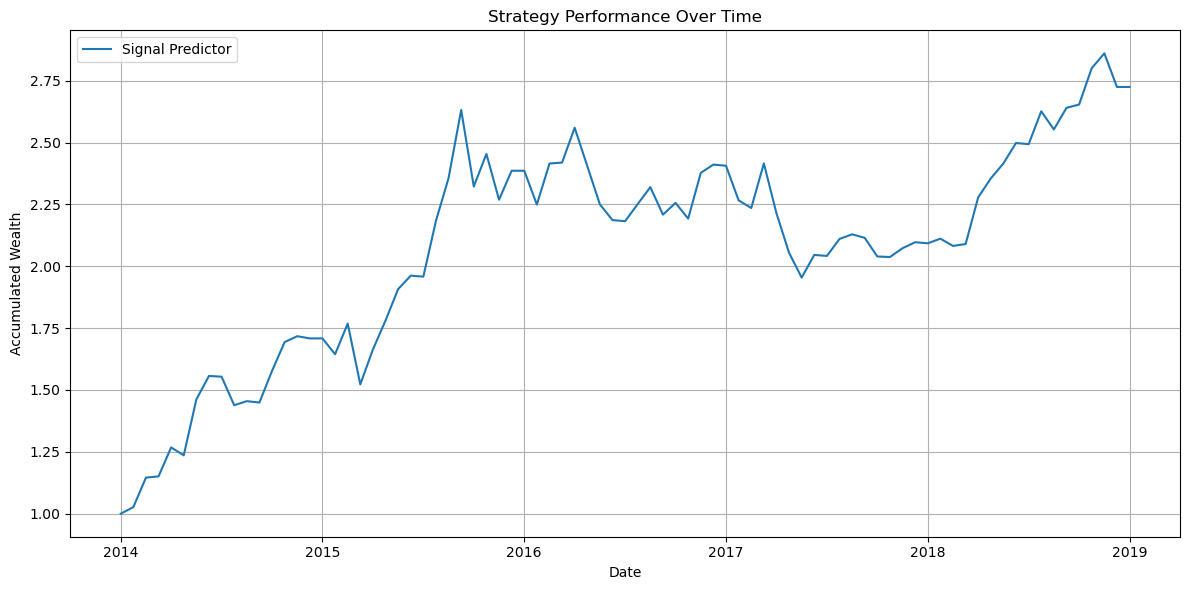

In [7]:
plot_cumulative_wealth(
    returns_dict={
        'Signal Predictor': realized_returns,
    }, 
    start_time=config.data_config.val_set_last_date, 
    end_time=config.data_config.end
)

In [8]:
realized_returns_attention_no_embed = realized_returns
pd.Series(realized_returns_attention_no_embed).to_csv('realized_returns_attention_embed.csv')